# ===============================
# Task 02: Customer Churn Prediction
# End-to-End ML Pipeline
# ===============================

**0. Import Required Libraries**

In [1]:
import pandas as pd
import numpy as np

# Visualization (optional but useful)
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn core
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model persistence
import joblib


**1. Download the Dataset**

In [3]:
!kaggle datasets download -d blastchar/telco-customer-churn
!unzip telco-customer-churn.zip

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Path to dataset files: /kaggle/input/telco-customer-churn


**2. Load the Dataset**

In [5]:
# Load Telco Customer Churn dataset
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Preview dataset
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**3. Basic Dataset Inspection**

In [6]:
# Dataset shape
print("Dataset Shape:", df.shape)

# Column info
df.info()

# Check missing values
df.isnull().sum()

Dataset Shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


**4. Target Variable Cleaning**

In [7]:
# Convert target variable to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Convert TotalCharges to numeric (it contains spaces)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing TotalCharges with median
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

/tmp/ipython-input-863496000.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


**5. Feature & Target Separation**

In [8]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

**6. Identify Numerical & Categorical Features**

In [9]:
# Numerical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)

Numeric Features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical Features: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


**7. Preprocessing Pipeline (ColumnTransformer)**

In [10]:
# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

**8. Train-Test Split**

In [11]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**9. Logistic Regression Pipeline**

In [12]:
# Create Logistic Regression pipeline
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train model
logreg_pipeline.fit(X_train, y_train)

# Predictions
y_pred_logreg = logreg_pipeline.predict(X_test)

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.8041163946061036
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409



**10. Random Forest Pipeline**

In [13]:
# Create Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train model
rf_pipeline.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7920511000709723
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.65      0.47      0.54       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



**11. Hyperparameter Tuning with GridSearchCV**

In [14]:
# Define parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

# GridSearchCV
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Fit GridSearch
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


**12. Evaluate Best Model**

In [15]:
# Predictions using best model
y_pred_best = best_model.predict(X_test)

# Final evaluation
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Tuned Model Accuracy: 0.7920511000709723
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.65      0.47      0.54       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



**13. Confusion Matrix Visualization**

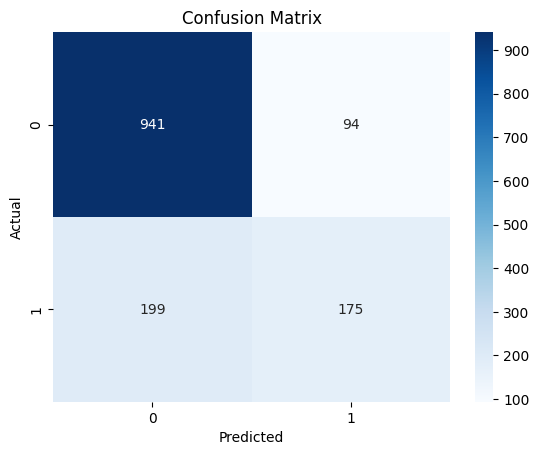

In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**14. Export Final Pipeline (Production-Ready)**

In [17]:
# Save the entire pipeline
joblib.dump(best_model, "churn_prediction_pipeline.joblib")

print("Pipeline saved successfully!")

Pipeline saved successfully!
